In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [14]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



# Split the data to training, testing, and validation subsets

In [15]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [16]:
def testLinearClassifier(a, X, y):
    # Add a bias term to the feature vectors
    X_bias = np.hstack((X, np.ones((X.shape[0], 1))))
    
    # Compute the predictions
    predictions = np.dot(X_bias, a)
    predicted_labels = (predictions > 0).astype(int)
    
    # Count the misclassifications
    misclassifications = np.sum(predicted_labels != y)
    
    return misclassifications



## Define and test gaussianClassifierWithIdentityCovariance 

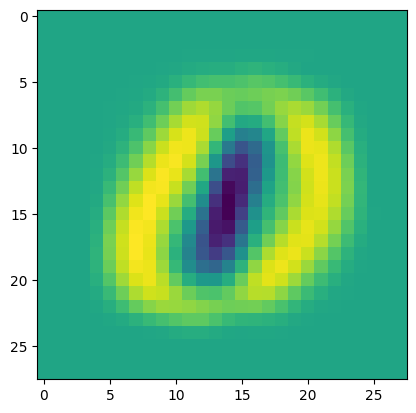

In [17]:
#------TRAINING CODE --------------

def gaussianClassifierWithIdentityCovariance(Xtrain, ytrain):
    # Split the dataset into two classes
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]

    # Compute the means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)

    # Compute the weights
    a = np.hstack(((mu1 - mu2), 0))  # Append 0 for bias term

    return a
    #YOUR CODE HERE


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)



## Define and test gaussianClassifierWithCommonCovariance 

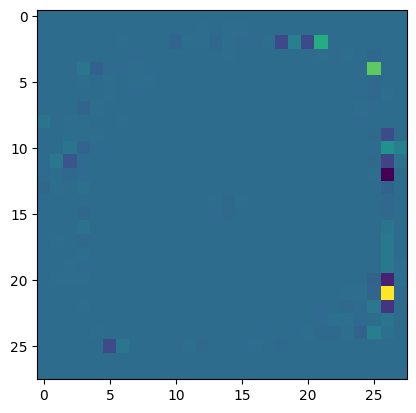

In [18]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain, ytrain):
    # Split the dataset into two classes
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]

    # Compute the means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)

    # Compute the common covariance matrix
    Sigma = np.cov(Xtrain.T)

    # Use pseudoinverse in place of regular inverse
    a = np.dot(np.linalg.pinv(Sigma), mu1 - mu2)
    a = np.hstack((a, 0))  # Append 0 for bias term

    return a

    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

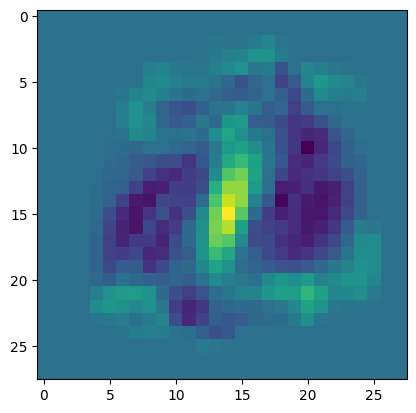

In [22]:
def logisticRegression(Xtrain, ytrain, iterations=100, step_size=1e-4, verbose= False):
    a = np.zeros(Xtrain.shape[1] + 1)  # Initialize weights with zeros

    # Add a bias term to the feature vectors
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    for i in range(iterations):
        # Calculate the model predictions
        predictions = expit(np.dot(X_bias, a))

        # Update the weights
        a -= step_size * np.dot(X_bias.T, (predictions - ytrain))

    return a
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)



In [25]:
def logisticRegressionWithRegularization(Xtrain, ytrain, iterations=100, step_size=1e-4, lam=0.1, verbose= False):
    a = np.zeros(Xtrain.shape[1] + 1)  # Initialize weights with zeros

    # Add a bias term to the feature vectors
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    for i in range(iterations):
        # Calculate the model predictions
        predictions = expit(np.dot(X_bias, a))

        # Gradient of the loss function with L2 regularization
        gradient = np.dot(X_bias.T, (predictions - ytrain)) + lam * a

        # Update the weights, skip the bias term for regularization
        a[0] -= step_size * np.dot(X_bias.T[0], (predictions - ytrain))
        a[1:] -= step_size * gradient[1:]

    return a

    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


TypeError: logisticRegressionWithRegularization() got an unexpected keyword argument 'lam'

In [ ]:
def optimizeHyperparameters(Xtrain, ytrain, Xval, yval, iterations=100, step_size=1e-4):
    # Define a set of possible lambda values
    lambda_values = np.logspace(-5, 1, num=50)

    best_lambda = None
    best_val_error = float('inf')

    # Iterate over all possible lambda values
    for lambda_reg in lambda_values:
        # Train a model with the current lambda value
        a = logisticRegressionWithRegularization(Xtrain, ytrain, iterations, step_size, lambda_reg)

        # Compute the error on the validation set
        val_error = testLinearClassifier(a, Xval, yval)

        # If this model is better than the previous best, update the best model
        if val_error < best_val_error:
            best_val_error = val_error
            best_lambda = lambda_reg

    return best_lambda


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW